<>:101: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\s'
<>:104: SyntaxWarning: invalid escape sequence '\s'
<>:101: SyntaxWarning: invalid escape sequence '\s'
<>:102: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\s'
<>:104: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1949272210.py:101: SyntaxWarning: invalid escape sequence '\s'
  X_train = pd.read_csv(base_path + "train/X_train.txt", sep='\s+', header=None)
/tmp/ipython-input-1949272210.py:102: SyntaxWarning: invalid escape sequence '\s'
  y_train = pd.read_csv(base_path + "train/y_train.txt", sep='\s+', header=None)[0]
/tmp/ipython-input-1949272210.py:103: SyntaxWarning: invalid escape sequence '\s'
  X_test = pd.read_csv(base_path + "test/X_test.txt", sep='\s+', header=None)
/tmp/ipython-input-1949272210.py:104: SyntaxWarning: invalid escape sequence '\s'
  y_test = pd

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7019 - loss: 0.7252 - val_accuracy: 0.9171 - val_loss: 0.2438
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9647 - loss: 0.1054 - val_accuracy: 0.9347 - val_loss: 0.1642
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9764 - loss: 0.0632 - val_accuracy: 0.9293 - val_loss: 0.2637
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9784 - loss: 0.0616 - val_accuracy: 0.9225 - val_loss: 0.2136
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9758 - loss: 0.0597 - val_accuracy: 0.9313 - val_loss: 0.2245
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9832 - loss: 0.0485 - val_accuracy: 0.9456 - val_loss: 0.1885
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9862 - loss: 0.0360 - val_accuracy: 0.9497 - val_loss: 0.1717
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9922 - loss: 0.0261 - val_accuracy: 0.9347 - 

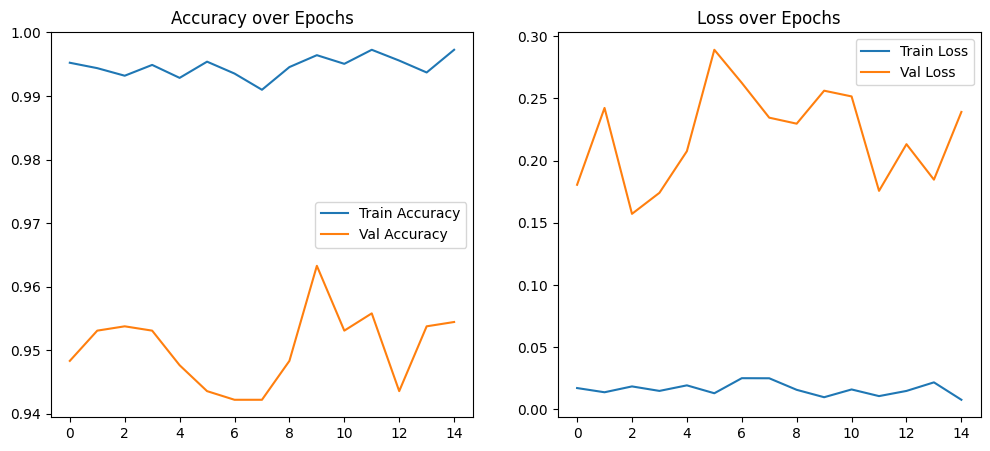

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


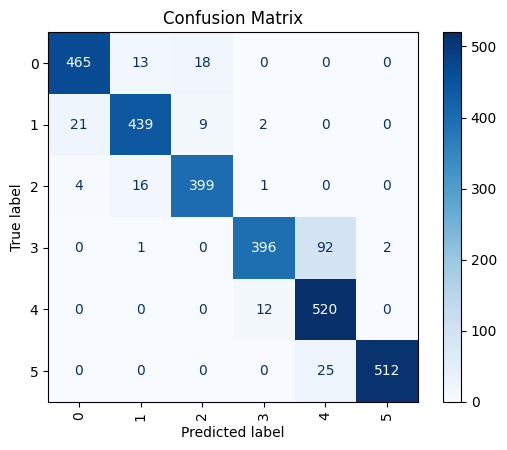

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, activations
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.query = layers.Dense(dim)
        self.key = layers.Dense(dim)
        self.value = layers.Dense(dim)
        self.out = layers.Dense(dim)
    def call(self, x):
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        D = x.shape[-1]
        H = self.num_heads
        d = self.head_dim
        Q = tf.reshape(self.query(x), (B, N, H, d))
        K = tf.reshape(self.key(x), (B, N, H, d))
        V = tf.reshape(self.value(x), (B, N, H, d))
        Q = tf.transpose(Q, perm=[0, 2, 1, 3])
        K = tf.transpose(K, perm=[0, 2, 1, 3])
        V = tf.transpose(V, perm=[0, 2, 1, 3])
        attn_score = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(d, tf.float32))
        attn_weight = tf.nn.softmax(attn_score, axis=-1)
        attn_out = tf.matmul(attn_weight, V)
        attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        attn_out = tf.reshape(attn_out, (B, N, D))
        return self.out(attn_out)

class CustomTransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads=4, ff_dim=128, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(dim, num_heads)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ff = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(dim),
        ])
        self.dropout = layers.Dropout(dropout)
    def call(self, x, training=False):
        attn_out = self.attn(x)
        x = self.norm1(x + self.dropout(attn_out, training=training))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out, training=training))
        return x

class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = layers.Conv1D(channels, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(channels, 3, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.ReLU()
    def call(self, x, training=False):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = out + residual
        return self.relu(out)

class ResNetTransformerClassifier(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, num_classes,
                 num_resnet_blocks=2, num_transformer_layers=2,
                 num_heads=4, ff_dim=128):
        super().__init__()
        self.fc0 = layers.Dense(hidden_dim)
        self.resnet_blocks = [ResNetBlock(1) for _ in range(num_resnet_blocks)]
        self.transformer_layers = [
            CustomTransformerEncoderLayer(hidden_dim, num_heads, ff_dim)
            for _ in range(num_transformer_layers)
        ]
        self.fc_out = layers.Dense(num_classes, activation=None)
    def call(self, x, training=False):
        x = self.fc0(x)
        x = tf.expand_dims(x, axis=1)
        x = tf.transpose(x, perm=[0, 2, 1])
        for block in self.resnet_blocks:
            x = block(x, training=training)
        x = tf.transpose(x, perm=[0, 2, 1])
        for layer in self.transformer_layers:
            x = layer(x, training=training)
        x = tf.squeeze(x, axis=1)
        logits = self.fc_out(x)
        probs = tf.nn.softmax(logits, axis=-1)
        return logits, probs


def load_har_data(base_path="/content/drive/MyDrive/Colab Notebooks/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/"):
    X_train = pd.read_csv(base_path + "train/X_train.txt", sep='\s+', header=None)
    y_train = pd.read_csv(base_path + "train/y_train.txt", sep='\s+', header=None)[0]
    X_test = pd.read_csv(base_path + "test/X_test.txt", sep='\s+', header=None)
    y_test = pd.read_csv(base_path + "test/y_test.txt", sep='\s+', header=None)[0]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_har_data()

X_train, X_test, y_train, y_test = load_har_data()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model = ResNetTransformerClassifier(
    input_dim=X_train.shape[1],
    hidden_dim=128,
    num_classes=num_classes,
    num_resnet_blocks=2,
    num_transformer_layers=2
)

inputs = tf.keras.Input(shape=(X_train.shape[1],))
logits, probs = model(inputs)
trainable_model = tf.keras.Model(inputs=inputs, outputs=probs)
trainable_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

trainable_model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=1)
loss, acc = trainable_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

# ✅ GPU 확인
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"✅ GPU 사용 중: {device_name}")
else:
    print("⚠️ GPU가 감지되지 않았습니다. 런타임 → 런타임 유형 변경 → GPU 선택하세요.")

# ✅ 모델 학습 및 기록 저장
history = trainable_model.fit(
    X_train, y_train,
    epochs=15, batch_size=64,
    validation_split=0.2,
    verbose=1
)

# ✅ 학습 그래프
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# ✅ 혼돈행렬
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = trainable_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

